<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Introduction" data-toc-modified-id="Introduction-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Introduction</a></span></li><li><span><a href="#Are-all-libraries-that-are-needed-available?" data-toc-modified-id="Are-all-libraries-that-are-needed-available?-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Are all libraries that are needed available?</a></span></li><li><span><a href="#Prepare-an-image-provider-class" data-toc-modified-id="Prepare-an-image-provider-class-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Prepare an image provider class</a></span></li><li><span><a href="#Build-a-Convolutional-Neural-Network-(CNN)" data-toc-modified-id="Build-a-Convolutional-Neural-Network-(CNN)-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Build a Convolutional Neural Network (CNN)</a></span></li></ul></div>

# Introduction

The goal of this notebook is to show you how to build a simple Convolutional Neural Network (CNN) for classification in Keras.

For this, first we need data! Search for open datasets of free images that show cars and bikes. E.g., Google has published the Open Image Dataset V4:

https://storage.googleapis.com/openimages/web/visualizer/index.htm

Prepare a folder data with two subfolders:
    car
    bike
and store some hundreds of training images for each object category in each of these folders.


# Are all libraries that are needed available?

In [15]:
import numpy as np
import tensorflow as tf
import keras
import cv2
import matplotlib
import matplotlib.pyplot as plt

print( "Your NumPy version is:      " + np.__version__ )
print( "Your TensorFlow version is: " + tf.__version__)
print( "Your Keras version is:      " + keras.__version__ )
print( "Your OpenCV version is:     " + cv2.__version__ )
print( "Your Matplotlib version is: " + matplotlib.__version__)

Your NumPy version is:      1.16.2
Your TensorFlow version is: 1.13.1
Your Keras version is:      2.2.4
Your OpenCV version is:     4.1.0
Your Matplotlib version is: 2.0.2


# Prepare an image provider class

We define a class ``image_provider`` that will give us a convenient access to the images.

Given a root folder (e.g. "C:\\data"), it automatically determines which subfolders are there (e.g. "C:\\data\\car" and "C:\\data\\bike"). Each subfolder is assumed to be one of the categories we are interested in (e.g. "car" and "bike").

An image provide object then stores a list of all training items:
    
        [filename1, class_id, class_name, teacher_vec]
        [filename2, class_id, class_name, teacher_vec]
        ...

In [36]:
import os
from os import listdir
from os.path import isdir, isfile, join

IMG_SIZE = (100,100)
    
class image_provider:
    
    #
    # Traverses all subfolders of the specified root_folder
    # and generates a list of the form:
    #
    # [ ["data/bikes/jfksdj43.jpg", "bikes",
    #   ["data/cars/bvcnm401.jpg", "cars"],
    #   ...
    # ]
    #
    def __init__(self, root_folder):
        
        self.all_training_items = []
       
        class_names = \
            [d for d in listdir(root_folder)
             if isdir(os.path.join(root_folder,d))]

        print("Under folder\n\t", root_folder,
              "\nI found the following subfolders/classes:")
        print(class_names)
        
        nr_classes = len(class_names)
        
        # For each subfolder ...
        for class_id, class_name in enumerate(class_names):
            
            subfolder_name = root_folder + "/" + class_name + "/"
            
            filenames = \
                [subfolder_name + f
                 for f in listdir(subfolder_name) if isfile(join(subfolder_name, f))]
            
            print("{} files in subfolder {}".format(len(filenames), subfolder_name) )
            
            # For each image filename in current subfolder ...
            for filename in filenames:
                
                teacher_vec = np.zeros( nr_classes )
                teacher_vec[class_id] = 1.0
                
                self.all_training_items.append(
                    [filename, class_id, class_name, teacher_vec] )              
        
        self.nr_images = len(self.all_training_items)
        print("There are {} images in total available.".format(self.nr_images))
        
        print("Here are the first 3 entries of the training items list generated:")
        print(self.all_training_items[:3])
        
    
    
    #   
    # Given an absolute filename,
    # load the image in using OpenCV,
    # then convert it to usual RGB color channel order
    # and scale values to be in range [0,1]
    #
    def load_image(self, absolute_filename):
        
        image = cv2.imread(absolute_filename)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
                
        image = cv2.resize(image, IMG_SIZE, interpolation=cv2.INTER_AREA)
        image = image * (1.0 / 255.0)
        
        return image
        
        
       
    #
    # Return the image from the dataset
    # with the specified index
    #
    def get_specific_image(self, idx):
        
        image_filename  = self.all_training_items[idx][0]
        class_id        = self.all_training_items[idx][1]
        class_name      = self.all_training_items[idx][2]
        teacher_vec     = self.all_training_items[idx][3]
        
        image = self.load_image(image_filename)
        
        return image, class_id, class_name, teacher_vec
    
    
    #
    # Return an OpenCV image and the class label
    # where the image is chosen randomly from the
    # list of all images.
    #
    def get_random_image(self):
        
        rnd_idx = np.random.randint(0, self.nr_images)
        return self.get_specific_image( rnd_idx )

Let's test the image provider class:

In [37]:
my_image_provider = image_provider( "V:\\01_job\\12_datasets\\01_imagenet_cars_vs_bikes" )

Under folder
	 V:\01_job\12_datasets\01_imagenet_cars_vs_bikes 
I found the following subfolders/classes:
['bikes', 'cars']
1344 files in subfolder V:\01_job\12_datasets\01_imagenet_cars_vs_bikes/bikes/
1307 files in subfolder V:\01_job\12_datasets\01_imagenet_cars_vs_bikes/cars/
There are 2651 images in total available.
Here are the first 3 entries of the training items list generated:
[['V:\\01_job\\12_datasets\\01_imagenet_cars_vs_bikes/bikes/n02834778_10.JPEG', 0, 'bikes', array([1., 0.])], ['V:\\01_job\\12_datasets\\01_imagenet_cars_vs_bikes/bikes/n02834778_10025.JPEG', 0, 'bikes', array([1., 0.])], ['V:\\01_job\\12_datasets\\01_imagenet_cars_vs_bikes/bikes/n02834778_10027.JPEG', 0, 'bikes', array([1., 0.])]]


Let us retrieve randomly one of the images and display it.

image has type <class 'numpy.ndarray'>
image has shape (100, 100, 3)
teacher vec: [0. 1.]


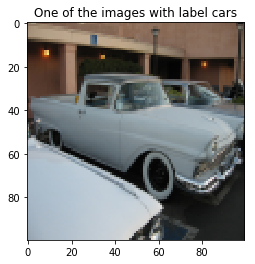

In [38]:
image, class_id, class_name, teacher_vec = \
    my_image_provider.get_random_image()
print("image has type", type(image))
print("image has shape", image.shape)
print("teacher vec:", teacher_vec)
plt.imshow(image)
plt.title("One of the images with label {}".format(class_name))
plt.show()

# Build a Convolutional Neural Network (CNN)

Now we define a simple CNN in Keras.

What we need to specify is the input shape of a single image:

    (image_height, image_width, nr_color_channels)
    
Further, we need to specify how many output neurons the CNN shall have. This corresponds to the number of object classes we want to discriminate (classifiy) with the CNN:

    e.g., nr_output_neurons = 2 ("car" vs. "bike")
    e.g., nr_output_neurons = 3 ("car" vs. "bike" vs. "truck")
    
And then there are a lot of "hyperparameters" (model parameters we have to set manually):

- how many conv layers?
- how many pooling layers?
- order of layers?
- for each conv layer:
  - nr of filters?
  - kernel side length?
  - kernel stride?
  - activation function to use?
- for each max-pooling layer:
  - kernel side length?
  - kernel stride?
- for the final MLP at the end:
  - nr of layers?
  - for each MLP layer:
    - nr of neurons?
    - activation function to use?

In [39]:
def build_a_cnn_model(input_shape_of_single_image, nr_output_neurons):

    model = Sequential()

    # 1. Define the feature hierarchy:
    
    # Layer 1
    nr_filter       = 32
    kernel_side_len = 4
    kernel_stride   = 2
    model.add(Conv2D(nr_filter,
                     kernel_size=(kernel_side_len, kernel_side_len),
                     strides=(kernel_stride, kernel_stride),
                     activation='relu',
                     input_shape=input_shape_of_single_image)
             )
    
    # Layer 2
    kernel_side_len = 2
    kernel_stride   = 2
    model.add(MaxPooling2D(pool_size=(kernel_side_len, kernel_side_len),
                           strides=(kernel_stride, kernel_stride))
             )

    # 2. Define the MLP part:
    model.add(Flatten())
    model.add(Dense(nr_output_neurons, activation='softmax'))

    return model

# end build_a_cnn_model